In [1]:
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement

import cv2
import time

In [2]:
import sys
sys.path.insert(0, '..')

from web_interaction.main import open_game, start_game, wait_loading
from web_interaction.main import fill_game_main_info_from_image
from web_interaction.main import apply_decompose_action, apply_user_story_action
from game.game import ProductOwnerGame
from environment.backlog_env import BacklogEnv
from environment.environment import ProductOwnerEnv
from environment.reward_sytem.base_reward_system import BaseRewardSystem
from environment.userstory_env import UserstoryEnv

from pipeline.study_agent import load_dqn_agent

from web_interaction import GameImageParser, GameCoordinator

In [3]:
agent = load_dqn_agent('../models/credit_start_model.pt')

c:\Users\kruto\OneDrive\Рабочий стол\forks\product_owner_rl\web_interaction\..\pipeline\study_agent.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent: DQN = torch.l

In [9]:
driver = open_game()

iframe = driver.find_element(by=By.ID, value='game_drop')

# open full screen
fullscreen_button = driver.find_element(by=By.CLASS_NAME, value="fullscreen_btn")
fullscreen_button.click()

height = iframe.rect["height"]  # 540 or 1028
width = iframe.rect["width"]  # 960 or 1920

wait_loading(iframe)

start_game(driver, iframe)

iframe.screenshot('game_state.png')

image = cv2.imread('game_state.png')

In [12]:
image_parser = GameImageParser('../web_interaction/templates')
game_coordinator = GameCoordinator(image_parser)
game = ProductOwnerGame()

In [13]:
game_coordinator.skip_tutorial(game)
game_coordinator.insert_user_stories_from_image(game, image)

In [14]:
game.userstories.stories_list

[UserStoryCard(S, loyalty=0.045, customers=3.0]

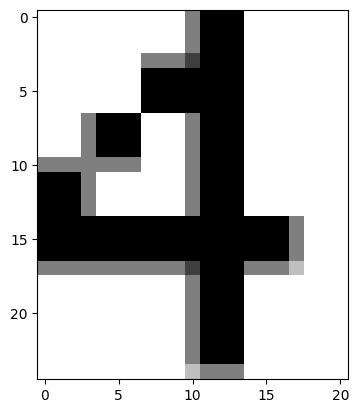

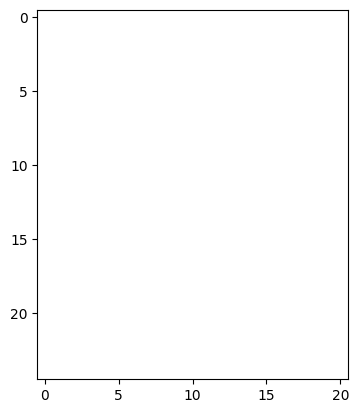

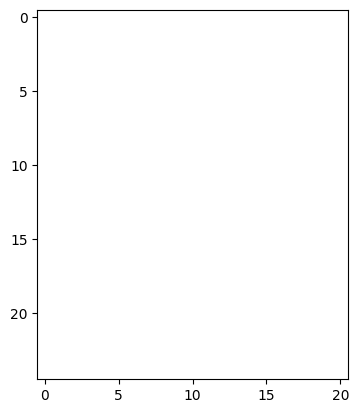

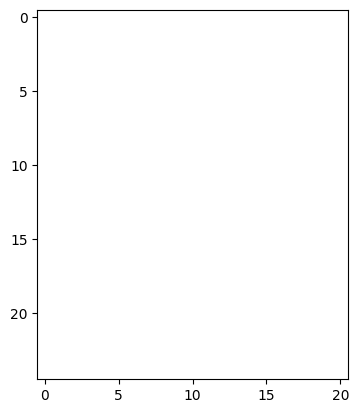

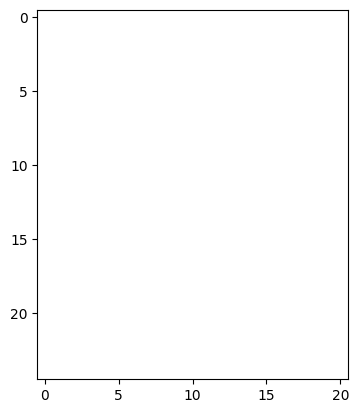

ValueError: could not convert string to float: '4eess'

In [15]:
fill_game_main_info_from_image(game, image)

print('Sprint', game.context.current_sprint)
print('Sprint hours', game.context.current_sprint_hours)
print('Money', game.context.get_money())
print('Loyalty', game.context.get_loyalty())
print('Customers', game.context.customers)
print('Credit', game.context.credit)

In [13]:
userstory_env = UserstoryEnv(4, 0, 0)
backlog_env = BacklogEnv(12, 0, 0, 0, 0, 0)
reward_system = BaseRewardSystem(config={})
env = ProductOwnerEnv(userstory_env, backlog_env, with_info=True, reward_system=reward_system)
env.game = game

In [14]:
from web_interaction.main import (
    apply_start_sprint_action,
    apply_release_action,
    apply_buy_statistical_research_action,
    apply_backlog_card_action
)


def apply_web_action(action: int, driver, iframe: WebElement, env: ProductOwnerEnv):
    if action == 0:  # start sprint

        apply_start_sprint_action(driver, iframe, width, height, env)

        return

    if action == 1:  # decompose

        apply_decompose_action(driver, iframe, width, height, env)

        return

    if action == 2:  # release

        apply_release_action(driver, iframe, width, height, env)

        return

    if action == 5:  # buy statistical research

        apply_buy_statistical_research_action(driver, iframe, env)

        return

    if action >= env.meta_action_dim:

        action -= env.meta_action_dim

    if action < env.userstory_env.max_action_num:

        apply_user_story_action(action, driver, iframe, env)

        return

    action -= env.userstory_env.max_action_num

    if action < env.backlog_env.backlog_max_action_num:

        apply_backlog_card_action(action, driver, iframe, env)

        return

    raise Exception(f"Unknown action: {action}")

Start user story action: 3
User story: S l:0.075 c:3.0
True
Start decomposition
frozenset({(0, 23), (2, 247), (1, 150)})
16.0
7.0
8.0
6.0
1.0
Start moving backlog card
Selected card Hours: 16.0, Color: frozenset({(0, 23), (2, 247), (1, 150)}), Label: S, Type: UserCardType.S
Found at position (1472, 349)
Clicked on card
Start moving backlog card
Selected card Hours: 1.0, Color: frozenset({(0, 23), (2, 247), (1, 150)}), Label: S, Type: UserCardType.S
Found at position (1559, 437)
Clicked on card
Start new sprint
Start new sprint
Start moving backlog card
Selected card Hours: 6.0, Color: frozenset({(0, 23), (2, 247), (1, 150)}), Label: S, Type: UserCardType.S
Found at position (1472, 437)
Clicked on card
Start moving backlog card
Selected card Hours: 7.0, Color: frozenset({(0, 23), (2, 247), (1, 150)}), Label: S, Type: UserCardType.S
Found at position (1472, 349)
Clicked on card
Start new sprint
Start moving backlog card
Selected card Hours: 8.0, Color: frozenset({(0, 23), (2, 247), (1, 1

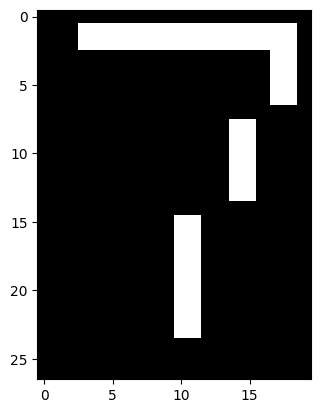

frozenset({(0, 255), (1, 211), (2, 143)})
9.0
7.0
15.0
7.0
Start moving backlog card
Selected card Hours: 15.0, Color: frozenset({(0, 255), (1, 211), (2, 143)}), Label: S, Type: UserCardType.S
Found at position (1472, 437)
Clicked on card
Start new sprint
Start moving backlog card
Selected card Hours: 7.0, Color: frozenset({(0, 255), (1, 211), (2, 143)}), Label: S, Type: UserCardType.S
Found at position (1559, 349)
Clicked on card
Start moving backlog card
Selected card Hours: 7.0, Color: frozenset({(0, 255), (1, 211), (2, 143)}), Label: S, Type: UserCardType.S
Found at position (1559, 349)
Clicked on card
Start new sprint
Start moving backlog card
Selected card Hours: 9.0, Color: frozenset({(0, 255), (1, 211), (2, 143)}), Label: S, Type: UserCardType.S
Found at position (1472, 349)
Clicked on card
Start new sprint
Start new sprint
Start user story action: 1
User story: S l:0.025 c:1.0
True
Start decomposition
frozenset({(0, 43), (2, 249), (1, 194)})
7.0
17.0
13.0
1.0
Start moving back

In [15]:
while not game.context.done:
    state = env.recalculate_state()
    # print(state)

    info = env.get_info()
    # print(info)

    action = agent.get_action(state, info)
    # print(action)

    time.sleep(1)
    apply_web_action(action, driver, iframe, env)

    if env.game.context.current_sprint >= 35:
        break

Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint
Start new sprint


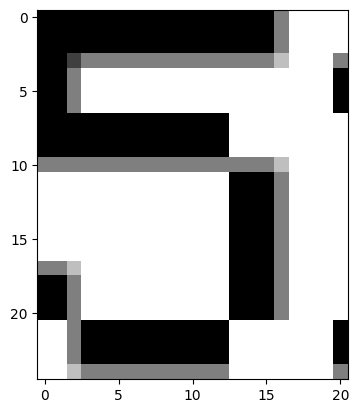

KeyboardInterrupt: Interrupted by user

In [16]:
while not game.context.done:
    time.sleep(1)
    apply_web_action(0, driver, iframe, env)

In [ ]:
iframe.rect

In [ ]:
raise Exception('Break before web driver exit')

In [16]:
driver.quit()